In [1]:
import pandas as pd
import numpy as np


In [2]:
transactional_data_1 = pd.read_csv('Transactional_data_retail_01.csv')
transactional_data_2 = pd.read_csv('Transactional_data_retail_02.csv')
customer_data = pd.read_csv('CustomerDemographics.csv')
product_info = pd.read_csv('ProductInfo.csv')

In [3]:
transactional_data_1['InvoiceDate'] = pd.to_datetime(transactional_data_1['InvoiceDate'], format='%d %B %Y')


transactional_data_2['InvoiceDate'] = pd.to_datetime(transactional_data_2['InvoiceDate'], format='%d-%m-%Y')


transactional_data = pd.concat([transactional_data_1, transactional_data_2], ignore_index=True)

In [4]:
data = pd.merge(transactional_data, product_info, on='StockCode', how='left')
data = pd.merge(data, customer_data, on='Customer ID', how='left')

In [5]:
data

,Invoice,StockCode,Quantity,Price,Customer ID,InvoiceDate,Description,Country
0,489434,85048,12,6.95,13085.0,2021-12-01,15CM CHRISTMAS GLASS BALL 20 LIGHTS,United Kingdom
1,489434,79323P,12,6.75,13085.0,2021-12-01,PINK CHERRY LIGHTS,United Kingdom
2,489434,79323P,12,6.75,13085.0,2021-12-01,"Unsaleable, destroyed.",United Kingdom
3,489434,79323P,12,6.75,13085.0,2021-12-01,NaN,United Kingdom
4,489434,79323W,12,6.75,13085.0,2021-12-01,WHITE CHERRY LIGHTS,United Kingdom
...,...,...,...,...,...,...,...,...
2115554,581587,22138,3,4.95,12680.0,2023-12-09,mouldy,NaN
2115555,581587,22138,3,4.95,12680.0,2023-12-09,damages,NaN
2115556,581587,22138,3,4.95,12680.0,2023-12-09,NaN,NaN
2115557,581587,POST,1,18.00,12680.0,2023-12-09,POSTAGE,NaN


In [6]:
data['total_sales'] = data['Quantity'] * data['Price']

In [7]:
print(data.isnull().sum())

# Fill missing data if necessary
data.fillna(method='ffill', inplace=True)

Invoice              0
StockCode            0
Quantity             0
Price                0
Customer ID     456094
InvoiceDate          0
Description     387589
Country        2055929
total_sales          0
dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_556\2291644746.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [8]:
data.isnull().sum()

Invoice        0
StockCode      0
Quantity       0
Price          0
Customer ID    0
InvoiceDate    0
Description    0
Country        0
total_sales    0
dtype: int64

EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
top_10_products = data.groupby('StockCode')['Quantity'].sum().nlargest(10).index
filtered_data = data[data['StockCode'].isin(top_10_products)]

In [12]:
sales_trends = filtered_data.groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().unstack()

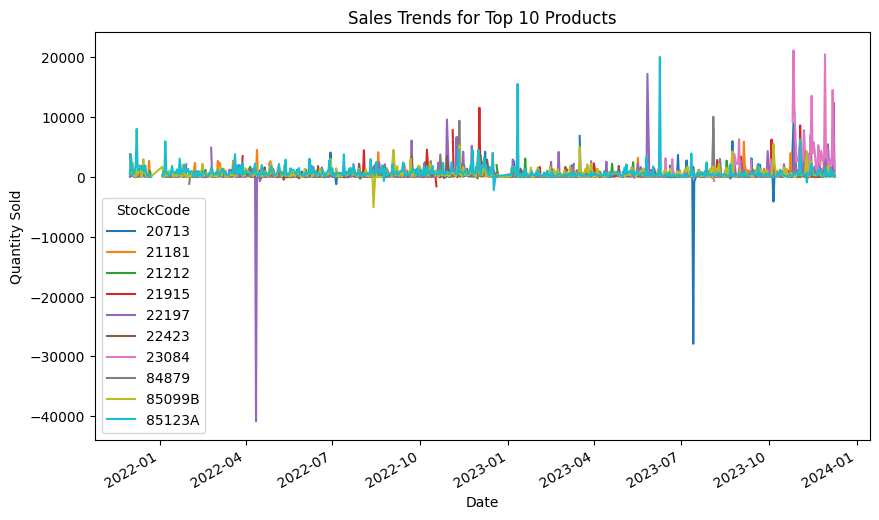

In [13]:
sales_trends.plot(figsize=(10, 6))
plt.title('Sales Trends for Top 10 Products')
plt.ylabel('Quantity Sold')
plt.xlabel('Date')
plt.show()

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


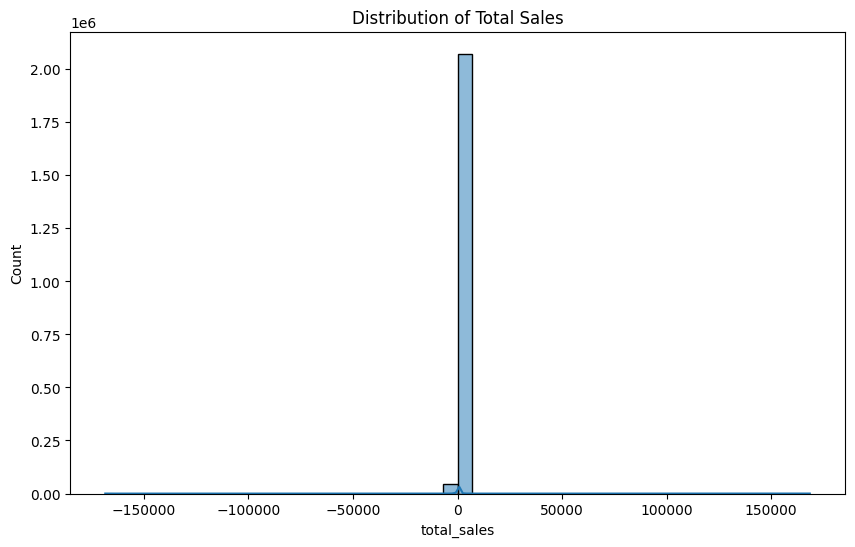

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['total_sales'], bins=50, kde=True)
plt.title('Distribution of Total Sales')
plt.show()


Time Series Model

In [15]:
! pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
product_data = filtered_data[filtered_data['StockCode'] == 1]
product_sales = product_data.set_index('InvoiceDate')['Quantity']

In [18]:
product_sales

Series([], Name: Quantity, dtype: int64)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Filter data for one product (e.g., product_id=1)
product_data = filtered_data[filtered_data['StockCode'] == 1]

# Check if there are any records for the specified product_id
if product_data.empty:
    print("Error: No data found for product_id=1.")
else:
    product_sales = product_data.set_index('InvoiceDate')['Quantity']

    # Check for NaN and infinite values
    product_sales = product_sales.dropna()
    product_sales = product_sales[~product_sales.isin([np.inf, -np.inf])]

    # Check if product_sales is empty after filtering
    if product_sales.empty:
        print("Error: The quantity_sold series is empty after filtering.")
    else:
        # Plot the sales data
        plt.figure(figsize=(10, 5))
        plt.plot(product_sales, label='Product Sales', color='blue')
        plt.title('Product Sales Over Time')
        plt.xlabel('Date')
        plt.ylabel('Quantity Sold')
        plt.legend()
        plt.show()

        # Perform ADF test for stationarity
        adf_result = adfuller(product_sales)
        print(f'ADF Statistic: {adf_result[0]}')
        print(f'p-value: {adf_result[1]}')

        # Check if the series is stationary
        if adf_result[1] > 0.05:
            print("The time series is not stationary. Differencing might be needed.")
            product_sales = product_sales.diff().dropna()
        
        # Check if differenced series is empty
        if product_sales.empty:
            print("Error: The differenced product_sales series is empty. Unable to proceed.")
        else:
            # Fit ARIMA model
            try:
                arima_model = ARIMA(product_sales, order=(5, 1, 0))
                arima_fit = arima_model.fit()
                
                # Forecast for the next 15 weeks
                forecast_arima = arima_fit.forecast(steps=15)
                print("ARIMA Forecast for the next 15 weeks:")
                print(forecast_arima)

            except Exception as e:
                print("An error occurred while fitting the ARIMA model:", str(e))


Error: No data found for product_id=1.


Unique product IDs in the dataset: ['84879' '21181' '85123A' '85099B' '21212' '22197' '20713' '21915' '22423'
 '23084']
Selected product_id=84879 as a fallback.


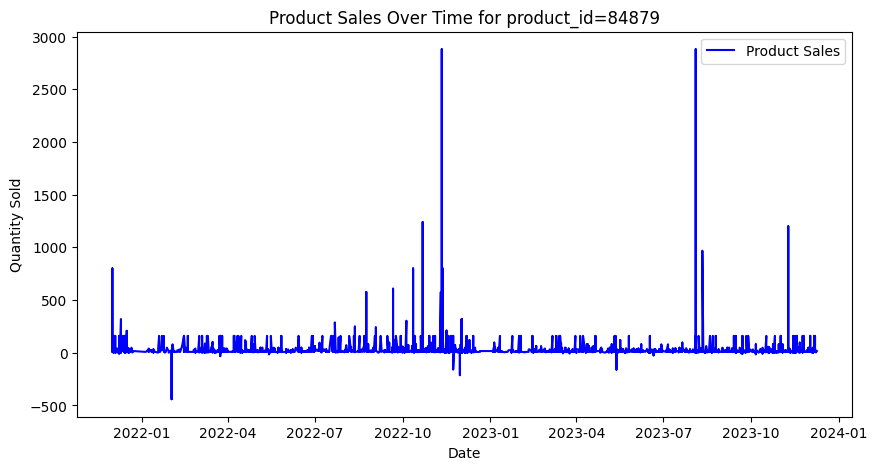

ADF Statistic: -13.901292185712126
p-value: 5.728035164572272e-26


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  

ARIMA Forecast for the next 15 weeks:
8880    16.0
8881    16.0
8882    16.0
8883    16.0
8884    16.0
8885    16.0
8886    16.0
8887    16.0
8888    16.0
8889    16.0
8890    16.0
8891    16.0
8892    16.0
8893    16.0
8894    16.0
Name: predicted_mean, dtype: float64


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Check available product IDs in the filtered_data DataFrame
unique_product_ids = filtered_data['StockCode'].unique()
print("Unique product IDs in the dataset:", unique_product_ids)

# Use an existing product_id from the list (if product_id=1 doesn't exist)
if 1 in unique_product_ids:
    selected_product_id = 1
else:
    selected_product_id = unique_product_ids[0]  # Change this index as needed
    print(f"Selected product_id={selected_product_id} as a fallback.")

# Filter data for the selected product
product_data = filtered_data[filtered_data['StockCode'] == selected_product_id]

# Check if there are any records for the specified product_id
if product_data.empty:
    print(f"Error: No data found for product_id={selected_product_id}.")
else:
    product_sales = product_data.set_index('InvoiceDate')['Quantity']

    # Check for NaN and infinite values
    product_sales = product_sales.dropna()
    product_sales = product_sales[~product_sales.isin([np.inf, -np.inf])]

    # Check if product_sales is empty after filtering
    if product_sales.empty:
        print("Error: The quantity_sold series is empty after filtering.")
    else:
        # Plot the sales data
        plt.figure(figsize=(10, 5))
        plt.plot(product_sales, label='Product Sales', color='blue')
        plt.title(f'Product Sales Over Time for product_id={selected_product_id}')
        plt.xlabel('Date')
        plt.ylabel('Quantity Sold')
        plt.legend()
        plt.show()

        # Perform ADF test for stationarity
        adf_result = adfuller(product_sales)
        print(f'ADF Statistic: {adf_result[0]}')
        print(f'p-value: {adf_result[1]}')

        # Check if the series is stationary
        if adf_result[1] > 0.05:
            print("The time series is not stationary. Differencing might be needed.")
            product_sales = product_sales.diff().dropna()
        
        # Check if differenced series is empty
        if product_sales.empty:
            print("Error: The differenced product_sales series is empty. Unable to proceed.")
        else:
            # Fit ARIMA model
            try:
                arima_model = ARIMA(product_sales, order=(5, 1, 0))
                arima_fit = arima_model.fit()
                
                # Forecast for the next 15 weeks
                forecast_arima = arima_fit.forecast(steps=15)
                print("ARIMA Forecast for the next 15 weeks:")
                print(forecast_arima)

            except Exception as e:
                print("An error occurred while fitting the ARIMA model:", str(e))


In [23]:
data

,Invoice,StockCode,Quantity,Price,Customer ID,InvoiceDate,Description,Country,total_sales
0,489434,85048,12,6.95,13085.0,2021-12-01,15CM CHRISTMAS GLASS BALL 20 LIGHTS,United Kingdom,83.40
1,489434,79323P,12,6.75,13085.0,2021-12-01,PINK CHERRY LIGHTS,United Kingdom,81.00
2,489434,79323P,12,6.75,13085.0,2021-12-01,"Unsaleable, destroyed.",United Kingdom,81.00
3,489434,79323P,12,6.75,13085.0,2021-12-01,"Unsaleable, destroyed.",United Kingdom,81.00
4,489434,79323W,12,6.75,13085.0,2021-12-01,WHITE CHERRY LIGHTS,United Kingdom,81.00
...,...,...,...,...,...,...,...,...,...
2115554,581587,22138,3,4.95,12680.0,2023-12-09,mouldy,United Kingdom,14.85
2115555,581587,22138,3,4.95,12680.0,2023-12-09,damages,United Kingdom,14.85
2115556,581587,22138,3,4.95,12680.0,2023-12-09,damages,United Kingdom,14.85
2115557,581587,POST,1,18.00,12680.0,2023-12-09,POSTAGE,United Kingdom,18.00


In [24]:
data.to_csv('preprocessed_data.csv',index=False)